# Example of ensemble runs


In [1]:
import numpy as np
import pandas as pd
import yaml
import h5py
from tqdm.notebook import tqdm
from mce.core.driver import Driver
from mce.util.io import retrieve_url

## Parameter ensemble

In [2]:
# Definition of parameters
with open('mce/core/attributes.yml') as f1:
    atts = yaml.safe_load(f1)['parameters']

In [3]:
def get_parms_ens(f_parms, cat, names, members):
    """Read parameter ensemble

    Parameters
    ----------
    f_parms
        h5py.File object
    cat
        Parameter category
    names
        Parameter names
    members
        Members

    Returns
    -------
        Array of selected parameters
    """
    return np.vstack([
        f_parms[f'{cat}/{name}'][members]
        for name in names
    ]).T

# Parameter names by category
pn_climate = ['a0', 'a1', 'a2', 'tau0', 'tau1', 'tau2', 'lambda']
pn_forcing = ['co2_alpha', 'co2_beta']
pn_forcing_scale = [
    'ch4', 'n2o', 'f_gases', 'montreal_gases',
    'o3_strat', 'o3_trop',
    'aerosols', 'bc_on_snow', 'land_use', 'h2o_strat',
]
pn_land = ['beta', 'fb_alpha']
pn_ocean = ['hls', 'hl1', 'hl2', 'hl3', 'eta1', 'eta2', 'eta3']

In [4]:
# Fetch two sets of parameter ensembles,
# a CMIP-based ensemble as a prior and a constrained ensemble from the prior
# Data files are not publicly available

labels_ens = ['Prior', 'Constrained']

# Use arbitrary 600 members
mm_prior = pd.read_csv(
    'untracked/parms_perturbed_members_prior.csv', index_col=0
).squeeze().tolist()[1000:1000+600]

mm_constrained = pd.read_csv(
    'untracked/parms_perturbed_members_constrained.csv',
    index_col=0
).squeeze().tolist()[-600:]

with h5py.File('untracked/parms_unconstrained_rcmip2.h5', 'r') as f1:
    # file contents
    f1.visititems(
        lambda name, obj:
        print(name, '(group)') if isinstance(obj, h5py.Group)
        else print(
            '{}: {}'.format(
                name,
                atts[name.split('/')[0]][name.split('/')[-1]]['long_name'],
            )
        )
    )
    # ensemble size
    print('Total unconstrained', f1['climate/a0'].shape[0])

    parms_ens = {
        label:
        {
            'climate': get_parms_ens(f1, 'climate', pn_climate, mm),
            'forcing': get_parms_ens(f1, 'forcing', pn_forcing, mm),
            'forcing_scale':
            get_parms_ens(f1, 'forcing_scale', pn_forcing_scale, mm),
            'ocean_1750': get_parms_ens(f1, 'ocean/init_1750', pn_ocean, mm),
            'ocean_1850': get_parms_ens(f1, 'ocean/init_1850', pn_ocean, mm),
            'land': get_parms_ens(f1, 'land', pn_land, mm),
        }
        for label, mm in
        zip(labels_ens, [mm_prior, mm_constrained])
    }

for k, v in parms_ens.items():
    print(k, v['climate'].shape[0])

climate (group)
climate/a0: Fraction of the first time constant contribution to the surface temperature change
climate/a1: Fraction of the second time constant contribution to the surface temperature change
climate/a2: Fraction of the third time constant contribution to the surface temperature change
climate/ecs: Equilibrium climate sensitivity
climate/ecs_reg: Equilibrium climate sensitivity based on conventional linear regression
climate/lambda: Climate feedback parameter
climate/tau0: First (shortest) time constant
climate/tau1: Second time constant
climate/tau2: Third time constant
climate/tcr: Transient climate response
forcing (group)
forcing/co2_alpha: Scaling factor of CO2 forcing
forcing/co2_beta: Amplification factor of CO2 forcing
forcing_scale (group)
forcing_scale/aerosols: Scaling factor for aerosols
forcing_scale/bc_on_snow: Scaling factor for surface albedo due to light-absorbing particles on snow and ice
forcing_scale/ch4: Scaling factor for CH4
forcing_scale/f_gases: 

In [5]:
def get_parms_driver(parms, year_pi, cco2_pi, ccref=None):
    """Return keyword arguments for driver

    Parameters
    ----------
    parms
        Categorized parameters
    cco2_pi
        Pre-industrial base year for the ocean module
    cco2_pi
        Pre-industrial CO2 concentration for the ocean module
    ccref, optional
        Reference CO2 concentration of CO2 forcing
        If None (default), use cco2_pi

    Returns
    -------
        Keyword arguments
    """
    if ccref is None:
        ccref = cco2_pi

    return {
        'kw_irm': {
            'asj': parms['climate'][0:3],
            'tauj': parms['climate'][3:6],
            'lamb': parms['climate'][6],
        },
        'kw_rfall': {
            'ccref': ccref,
            'alpha': parms['forcing'][0],
            'beta': parms['forcing'][1],
        },
        'kw_ocean': {
            'cco2_pi': cco2_pi,
            'hlk': parms[f'ocean_{year_pi}'][0:4],
            'etak': parms[f'ocean_{year_pi}'][4:7],
        },
        'kw_land': {
            'beta': parms['land'][0],
            'fb_alpha': parms['land'][1],
        },
    }

## Scenario data from RCMIP2

In [6]:
url = 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0'

fn = 'rcmip-emissions-annual-means-v5-1-0.csv'
df = pd.read_csv(retrieve_url(f'./datain/rcmip/{fn}', f'{url}/{fn}'))
df_rcmip_emis = (
    df
    .loc[df['Region']=='World']
    .set_index(df.columns[:7].to_list())
    .rename(columns=int)
)

fn = 'rcmip-concentrations-annual-means-v5-1-0.csv'
df = pd.read_csv(retrieve_url(f'./datain/rcmip/{fn}', f'{url}/{fn}'))
df_rcmip_conc = (
    df
    .loc[df['Region']=='World']
    .set_index(df.columns[:7].to_list())
    .rename(columns=int)
)

fn = 'rcmip-radiative-forcing-annual-means-v5-1-0.csv'
df = pd.read_csv(retrieve_url(f'./datain/rcmip/{fn}', f'{url}/{fn}'))
df_rcmip_rf = (
    df
    .set_index(df.columns[:7].to_list())
    .rename(columns=int)
)

[2024-10-07 11:54:06 mce.util.io] INFO:Use local file datain/rcmip/rcmip-emissions-annual-means-v5-1-0.csv retrieved from https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv on 2024-05-25
[2024-10-07 11:54:07 mce.util.io] INFO:Use local file datain/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv retrieved from https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv on 2024-06-20
[2024-10-07 11:54:07 mce.util.io] INFO:Use local file datain/rcmip/rcmip-radiative-forcing-annual-means-v5-1-0.csv retrieved from https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-radiative-forcing-annual-means-v5-1-0.csv on 2024-09-28


In [7]:
class InputRcmip:
    def __init__(self, df_emis, df_conc, df_rf):
        self.df_emis = df_emis
        self.df_conc = df_conc
        self.df_rf = df_rf

        self.id_vars = df_emis.index.names

    def _rename_species(self, x):
        return (
            x
            .split('|')[-1]
            .replace('CFC', 'CFC-')
            # .replace('HCFC', 'HCFC-')
            .replace('Halon', 'Halon-')
            .replace('HFC', 'HFC-')
            .replace('HFC-4310mee', 'HFC-43-10mee')
            .replace('C4F10', 'n-C4F10')
            .replace('C5F12', 'n-C5F12')
            .replace('C6F14', 'n-C6F14')
            .replace('cC4F8', 'c-C4F8')
        )

    def get_cco2(self, scenario, year):
        if isinstance(year, (tuple, list)):
            year = slice(*year)

        d_cco2 = (
            self.df_conc
            .groupby(['Scenario', 'Variable'])
            .get_group((scenario, 'Atmospheric Concentrations|CO2'))
            .squeeze()
            .dropna()
            .loc[year]
        )

        return d_cco2

    def get_cghg(self, scenario, year):
        if isinstance(year, (tuple, list)):
            year = slice(*year)

        id_vars_excl = [
            x for x in self.id_vars if x not in ['Variable', 'Unit']
        ]

        df_cghg = (
            self.df_conc
            .groupby('Scenario')
            .get_group(scenario)
            .dropna(axis=1)
            .droplevel(id_vars_excl)
            .rename(self._rename_species, level='Variable')
            .loc[:, year]
        )

        return df_cghg

    def get_rf_other(self, scenario, year):
        if isinstance(year, (tuple, list)):
            year = slice(*year)

        id_vars_excl = [
            x for x in self.id_vars if x not in ['Variable']
        ]
        df = (
            self.df_rf
            .groupby('Scenario')
            .get_group(scenario)
            .dropna(axis=1)
            .droplevel(id_vars_excl)
            .loc[:, year]
        )

        map_variable_rf = {
            'Aerosols': 'aerosols',
            'Tropospheric Ozone': 'o3_trop',
            'Stratospheric Ozone': 'o3_strat',
            'Albedo Change': 'land_use',
            'BC on Snow': 'bc_on_snow',
            'CH4 Oxidation Stratospheric H2O': 'h2o_strat',
            'Contrails and Contrail-induced Cirrus': 'contrails',
            'Solar': 'solar',
            'Volcanic': 'volcanic',
        }

        df_rf_other = df.loc[[
            x.split('|')[-1] in map_variable_rf
            for x in df.index.get_level_values('Variable')
        ]].rename(
            lambda x: map_variable_rf[x.split('|')[-1]],
            level='Variable',
        )

        return df_rf_other

input = InputRcmip(df_rcmip_emis, df_rcmip_conc, df_rcmip_rf)

In [8]:
cco2_1750 = input.get_cco2('historical', 1750)
cco2_1850 = input.get_cco2('historical', 1850)
cco2_1750, cco2_1850

(277.1470031738281, 284.3169987996419)

## CO2-only concentration-driven runs

In [9]:
# Using an idealized 1%-per-year increase trajectory
scenario = '1pctCO2'
d_cco2 = input.get_cco2(scenario, (1850, 2000))

In [10]:
# Define output variables
seconds_per_year = 3.15569e7
earth_area = 5.10e14 # m^2
outform = {
    'variables': [
        'eco2', 'ctot', 'coct', 'cocf', 'cbsf', 'cbst',
        'tas', 'thc', 'rtnt', 'abf', 'tcre', 'erf',
    ],
    'conversion': [
        # from J/spy/m^2 (spy=seconds per year) to ZJ
        ('thc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
    ],
}

In [11]:
nsize = 600
dfout_ens = {k: {} for k in parms_ens}

for name, parms in tqdm(parms_ens.items(), leave=False):
    for im in tqdm(range(nsize), leave=False):
        parms1 = {k: v[im] for k, v in parms.items()}
        drv = Driver(
            d_cco2.index.values, cco2=d_cco2.values,
            **get_parms_driver(parms1, 1850, cco2_1850),
        )
        df = drv.run(outform)
        dfout_ens[name][im] = df

    dfout_ens[name] = pd.concat(dfout_ens[name], names=['Member', 'Variable'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [12]:
outpath = 'untracked/out_ens_rcmip2.h5'

with h5py.File(outpath, 'w') as f1:
    f1.create_dataset(f'{scenario}/input/time', data=d_cco2.index.values)
    f1.create_dataset(f'{scenario}/input/cco2', data=d_cco2.values)

    for ensemble, df in dfout_ens.items():
        for variable, df1 in df.groupby('Variable'):
            f1.create_dataset(
                f'{scenario}/{ensemble}/{variable}',
                data=df1.droplevel('Variable').values,
                chunks=True,
            )

# Concentration-driven historical runs

Using multi-agents forcing, staring from 1750

In [13]:
scenario = 'historical'
df_cghg = input.get_cghg(scenario, (1750, None))
df_rf_other = input.get_rf_other(scenario, (1750, None))

In [14]:
# GHG concentrations to forcing without climate interaction
drv = Driver([0], cco2=[cco2_1750]) # dummy driver instance
df = drv.forcing.ghg_concentrations_to_forcing(df_cghg).droplevel(1)
df_erf_ghg = df.groupby([drv.forcing.ghgs[x].category for x in df.index]).sum()

In [15]:
# Categorized non-CO2 forcing
df_rf_base = pd.concat([df_erf_ghg.drop('co2'), df_rf_other])
df_rf_base

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ch4,0.001429,0.001709,0.002395,0.002870,0.003237,0.003581,0.004023,0.004328,0.004530,0.004461,...,0.513092,0.513079,0.515174,0.518764,0.520141,0.522299,0.524243,0.525038,0.527779,0.531101
f_gases,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021934,0.023631,0.025376,0.027170,0.028682,0.030658,0.032837,0.034761,0.037583,0.039603
montreal_gases,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.361339,0.361356,0.361272,0.361443,0.361155,0.361117,0.360692,0.360061,0.359833,0.358995
n2o,0.013883,0.013989,0.014110,0.014278,0.014436,0.014564,0.014666,0.014729,0.014849,0.014982,...,0.167234,0.169841,0.172132,0.175101,0.177350,0.180116,0.183376,0.186088,0.188982,0.192377
aerosols,0.000000,0.000836,0.001212,0.000801,-0.000571,0.000063,0.000618,-0.001421,-0.000764,-0.000720,...,-1.387485,-1.398719,-1.388067,-1.367507,-1.329220,-1.321976,-1.330262,-1.320120,-1.308953,-1.308580
land_use,0.000000,-0.000229,-0.000459,-0.000688,-0.000918,-0.001147,-0.001377,-0.001606,-0.001836,-0.002065,...,-0.195649,-0.195983,-0.196318,-0.196653,-0.196988,-0.197322,-0.197657,-0.197992,-0.198326,-0.198661
bc_on_snow,0.000000,-0.000281,-0.000378,-0.000291,0.000017,0.000016,-0.000326,0.000566,0.000257,0.000220,...,0.076119,0.077084,0.081136,0.078962,0.079160,0.085433,0.083331,0.085887,0.084253,0.086328
h2o_strat,0.000000,0.000035,0.000121,0.000180,0.000226,0.000269,0.000325,0.000363,0.000388,0.000379,...,0.065072,0.065069,0.065338,0.065800,0.065977,0.066255,0.066504,0.066606,0.066959,0.067386
contrails,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020012,0.020250,0.020722,0.020471,0.019395,0.020269,0.020810,0.021098,0.021369,0.021474
o3_strat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.057565,-0.056642,-0.056207,-0.055470,-0.054435,-0.053786,-0.053214,-0.052651,-0.052049,-0.051391


In [16]:
# Define output variables
outform = {
    'variables': [
        'eco2', 'ctot', 'coct', 'cocf', 'cbsf', 'cbst',
        'tas', 'thc', 'rtnt', 'abf', 'tcre',
        'erf', 'erf|CO2', 'erf|non-CO2',
    ],
    'variables_derived': [
        # derive gmst and ohc from tas and thc by simple scaling
        ('gmst', ['tas', 1.04, '/'],
        'Surface air ocean blended temperature change', 'degC'),
        ('ohc', ['thc', 1.08, '/'],
        'Ocean heat content change', 'J/spy/m^2'), 
    ],
    'conversion': [
        # from J/spy/m^2 (spy=seconds per year) to ZJ
        ('thc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
        ('ohc', seconds_per_year * earth_area * 1e-21, 'ZJ'),
    ],
}

In [17]:
d_cco2 = df_cghg.loc[('CO2', 'ppm')]
dfout_ens = {k: {} for k in parms_ens}

for name, parms in tqdm(parms_ens.items(), leave=False):
    for im in tqdm(range(nsize), leave=False):
        parms1 = {k: v[im] for k, v in parms.items()}
        d_scale = pd.Series(
            parms1['forcing_scale'],
            index=pn_forcing_scale,
        ).reindex(df_rf_base.index, fill_value=1.)
        df_erf_nonco2 = df_rf_base.mul(d_scale, axis=0)
        drv = Driver(
            d_cco2.index.values, cco2=d_cco2.values,
            erf_nonco2=df_erf_nonco2.sum().values,
            **get_parms_driver(parms1, 1750, cco2_1750),
        )
        df = drv.run(outform)
        dfout_ens[name][im] = df

    dfout_ens[name] = pd.concat(dfout_ens[name], names=['Member', 'Variable'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [18]:
with h5py.File(outpath, 'a') as f1:
    f1.create_dataset(f'{scenario}/input/time', data=d_cco2.index.values)
    f1.create_dataset(f'{scenario}/input/cco2', data=d_cco2.values)

    for k, v in df_rf_base.iterrows():
        f1.create_dataset(f'{scenario}/input/rf__{k}', data=v.values)

    for ensemble, df in dfout_ens.items():
        for variable, df1 in df.groupby('Variable'):
            variable = (
                variable
                .replace('|', '__')
                .replace('non-CO2', 'nonco2')
                .replace('CO2', 'co2')
            )
            f1.create_dataset(
                f'{scenario}/{ensemble}/{variable}',
                data=df1.droplevel('Variable').values,
                chunks=True,
            )

# Concentration-driven SSP scenario runs

Using multi-agents forcing of SSP2-4.5, staring from 1850

In [19]:
scenario = 'ssp245'
# Here, read data from 1750, but drop the period of 1750-1849
df_cghg = input.get_cghg(scenario, (1750, 2100))
df_rf_other = input.get_rf_other(scenario, (1750, 2100))

In [20]:
# GHG concentrations to forcing without climate interaction
drv = Driver([0], cco2=[cco2_1750]) # dummy driver instance
df = drv.forcing.ghg_concentrations_to_forcing(df_cghg).droplevel(1)
df_erf_ghg = df.groupby([drv.forcing.ghgs[x].category for x in df.index]).sum()

In [21]:
# Categorized non-CO2 forcing
# 1750-1849 period is dropped; no adjustment is applied
df_rf_base = pd.concat([df_erf_ghg.drop('co2'), df_rf_other]).loc[:, 1850:]
df_rf_base

,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
ch4,4.977546e-02,4.987614e-02,5.033398e-02,5.109210e-02,5.190273e-02,5.287833e-02,5.377010e-02,5.477777e-02,5.593447e-02,5.717304e-02,...,0.483927,0.482260,0.480673,0.479167,0.477731,0.476364,0.475060,0.473818,0.472630,0.471493
f_gases,3.017980e-08,3.288247e-08,3.593382e-08,3.899821e-08,4.207088e-08,4.515681e-08,4.825765e-08,5.137505e-08,5.451063e-08,5.776008e-08,...,0.155949,0.156489,0.156982,0.157431,0.157840,0.158209,0.158540,0.158836,0.159098,0.159328
montreal_gases,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.121738,0.120226,0.118735,0.117266,0.115820,0.114394,0.112990,0.111606,0.110243,0.108899
n2o,1.073941e-02,1.100692e-02,1.127779e-02,1.162905e-02,1.199117e-02,1.238240e-02,1.277721e-02,1.313148e-02,1.342692e-02,1.393447e-02,...,0.342685,0.343230,0.343735,0.344205,0.344639,0.345036,0.345397,0.345725,0.346016,0.346272
aerosols,-3.947552e-02,-3.826972e-02,-3.870359e-02,-4.055589e-02,-4.847449e-02,-4.791003e-02,-5.021529e-02,-5.218209e-02,-5.370057e-02,-5.644665e-02,...,-0.527044,-0.523812,-0.520573,-0.517328,-0.514076,-0.510818,-0.507553,-0.504281,-0.501002,-0.497717
land_use,-3.125688e-02,-3.196075e-02,-3.266462e-02,-3.336848e-02,-3.407235e-02,-3.477622e-02,-3.548009e-02,-3.618396e-02,-3.688782e-02,-3.759169e-02,...,-0.193391,-0.192117,-0.190828,-0.189526,-0.188210,-0.186880,-0.185536,-0.184178,-0.182806,-0.181421
bc_on_snow,5.343449e-03,4.842183e-03,4.626548e-03,4.854602e-03,5.782621e-03,5.594082e-03,5.369415e-03,6.081800e-03,6.348239e-03,6.213890e-03,...,0.010035,0.009614,0.009193,0.008772,0.008351,0.007930,0.007509,0.007088,0.006667,0.006246
h2o_strat,6.061261e-03,6.073903e-03,6.131403e-03,6.226620e-03,6.328439e-03,6.450986e-03,6.563009e-03,6.689603e-03,6.834931e-03,6.990555e-03,...,0.061248,0.061034,0.060829,0.060635,0.060450,0.060275,0.060107,0.059947,0.059794,0.059648
contrails,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.356368e-10,2.322624e-10,4.785243e-10,7.666280e-10,7.860864e-10,...,0.077742,0.078649,0.079556,0.080462,0.081369,0.082276,0.083182,0.084089,0.084996,0.085902
o3_strat,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-0.012453,-0.012230,-0.012015,-0.011807,-0.011603,-0.011403,-0.011208,-0.011017,-0.010829,-0.010646


In [22]:
d_cco2 = df_cghg.loc[('CO2', 'ppm'), 1850:]
dfout_ens = {k: {} for k in parms_ens}

for name, parms in tqdm(parms_ens.items(), leave=False):
    for im in tqdm(range(nsize), leave=False):
        parms1 = {k: v[im] for k, v in parms.items()}
        d_scale = pd.Series(
            parms1['forcing_scale'],
            index=pn_forcing_scale,
        ).reindex(df_rf_base.index, fill_value=1.)
        df_erf_nonco2 = df_rf_base.mul(d_scale, axis=0)
        # forcing base year is set to 1750
        drv = Driver(
            d_cco2.index.values, cco2=d_cco2.values,
            erf_nonco2=df_erf_nonco2.sum().values,
            **get_parms_driver(parms1, 1850, cco2_1850, cco2_1750),
        )
        df = drv.run(outform)
        dfout_ens[name][im] = df

    dfout_ens[name] = pd.concat(dfout_ens[name], names=['Member', 'Variable'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [23]:
with h5py.File(outpath, 'a') as f1:
    f1.create_dataset(f'{scenario}/input/time', data=d_cco2.index.values)
    f1.create_dataset(f'{scenario}/input/cco2', data=d_cco2.values)

    for k, v in df_rf_base.iterrows():
        f1.create_dataset(f'{scenario}/input/rf__{k}', data=v.values)

    for ensemble, df in dfout_ens.items():
        for variable, df1 in df.groupby('Variable'):
            variable = (
                variable
                .replace('|', '__')
                .replace('non-CO2', 'nonco2')
                .replace('CO2', 'co2')
            )
            f1.create_dataset(
                f'{scenario}/{ensemble}/{variable}',
                data=df1.droplevel('Variable').values,
                chunks=True,
            )

## Time series plot

In [24]:
import matplotlib as mpl
import textwrap
from mce.util.plot_base import PlotBase

In [25]:
# Plot module
myplt = PlotBase()

In [26]:
qvals = [0.17, 0.5, 0.83]

In [30]:
# Definition of parameters
with open('mce/core/attributes.yml') as f1:
    atts = yaml.safe_load(f1)

### 1pctCO2 runs

In [27]:
scenario = '1pctCO2'
variable_order = [
    'cco2', 'erf', 'tas',
    'coct', 'cbst', 'ctot',
    'eco2', 'abf', 'tcre',
]
ensemble_order = ['Prior', 'Constrained']

with h5py.File(outpath, 'r') as f1:
    grp = f1[f'{scenario}/input']
    din = {k: v[:] for k, v in grp.items()}

    dout = {}
    for ens in ensemble_order:
        d1 = dout.setdefault(ens, {})
        for v1 in variable_order:
            if v1 in din:
                continue

            d1[v1] = np.quantile(
                f1[f'{scenario}/{ens}/{v1}'][:], qvals, axis=0,
            )

In [28]:
alpha = 0.33
handles = [
    mpl.lines.Line2D([0], [0], color='k'),
    mpl.lines.Line2D([0], [0], color='C0'),
    mpl.lines.Line2D([0], [0], color='C1'),
    mpl.patches.Rectangle((0, 0), 1, 1, color='C0', alpha=alpha),
    mpl.patches.Rectangle((0, 0), 1, 1, color='C1', alpha=alpha),
]

qlab = '–'.join([str(int(x * 100)) for x in qvals[::2]])
labels = [
    'Input',
] + [
    f'{ens} median' for ens in ensemble_order
] + [
    f'{ens} {qlab}%' for ens in ensemble_order
]

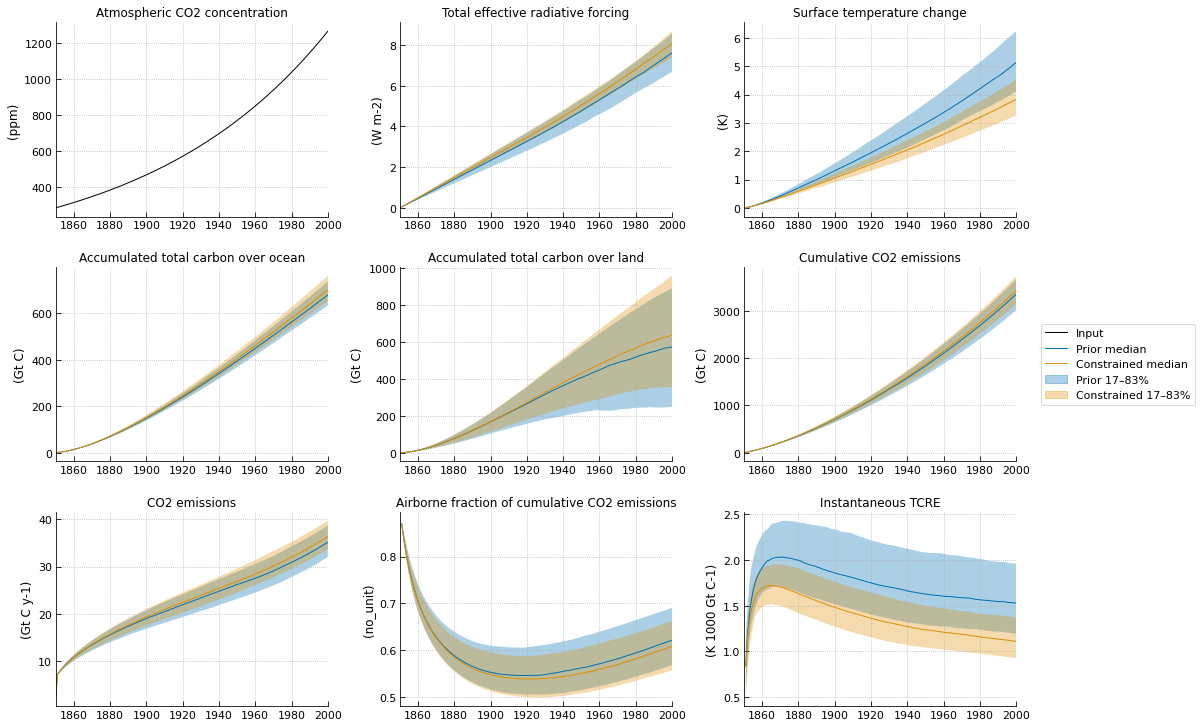

In [31]:
year_lim = (1850, 2000)
idx_year = pd.Index(din['time'])
slc = slice(
    idx_year.get_loc(year_lim[0]),
    idx_year.get_loc(year_lim[1]) + 1,
)
time = din['time'][slc]

myplt.init_regular(
    len(variable_order), col=3,
    kw_space={'height': 2.7, 'wspace': 1.},
)

for n, v1 in enumerate(variable_order):
    ax = myplt(n)

    if v1 in din:
        ax.plot(time, din[v1][slc], color='k')

    else:
        for i, ens in enumerate(ensemble_order):
            color = f'C{i}'
            ax.fill_between(
                time,
                y1=dout[ens][v1][2][slc],
                y2=dout[ens][v1][0][slc],
                edgecolor='none', facecolor=color, alpha=alpha,
            )
            ax.plot(time, dout[ens][v1][1][slc], color=color)

    ax.set_xlim(*year_lim)
    att = atts['variables'][v1]
    ax.set_title(att['long_name'])
    ax.set_ylabel('({})'.format(att['units']))
    ax.grid()

_ = myplt.figure.legend(
    handles, labels,
    bbox_to_anchor=myplt.get_fig_position_relto_axes((1.02, 0.5)),
    loc='center left',
)

### historical runs

In [32]:
scenario = 'historical'
variable_order = [
    'cco2', 'gmst', 'ohc',
    'erf__co2', 'erf__aerosols', 'erf__natural',
    'coct', 'cbst', 'ctot',
]

with h5py.File(outpath, 'r') as f1:
    grp = f1[f'{scenario}/input']
    din = {k: v[:] for k, v in grp.items()}

    # Natural factors are not perturbed in this case
    din['erf__natural'] = din['rf__solar'] + din['rf__volcanic']

    dout = {}
    for ens in ensemble_order:
        d1 = dout.setdefault(ens, {})
        for v1 in variable_order:
            if v1 in din:
                continue

            try:
                d1[v1] = np.quantile(
                    f1[f'{scenario}/{ens}/{v1}'][:], qvals, axis=0,
                )
            except:
                d1[v1] = None

In [33]:
# Additional variable attributes
atts_ext = {
    'gmst': {
        'long_name': 'Surface air ocean blended temperature change',
        'units': 'K',
    },
    'ohc': {
        'long_name': 'Ocean heat content change',
        'units': 'ZJ',
    },
    'erf__aerosols': {
        'long_name': 'Effective radiative forcing of aerosols',
        'units': 'W m-2',
    },
    'erf__natural': {
        'long_name': 'Effective radiative forcing of natural factors',
        'units': 'W m-2',
    },
}

In [34]:
# Variables to be retrieved
[k for k, v in dout['Prior'].items() if v is None]

['erf__aerosols']

In [35]:
df_scale = pd.concat({
    ens: pd.DataFrame( parms_ens[ens]['forcing_scale'],
        columns=pn_forcing_scale,
    )
    for ens in ensemble_order
}, axis=1)

In [36]:
for ens in ensemble_order:
    dout[ens]['erf__aerosols'] = np.quantile(
        df_scale[(ens, 'aerosols')].values[:, None] * din['rf__aerosols'],
        qvals, axis=0,
    )

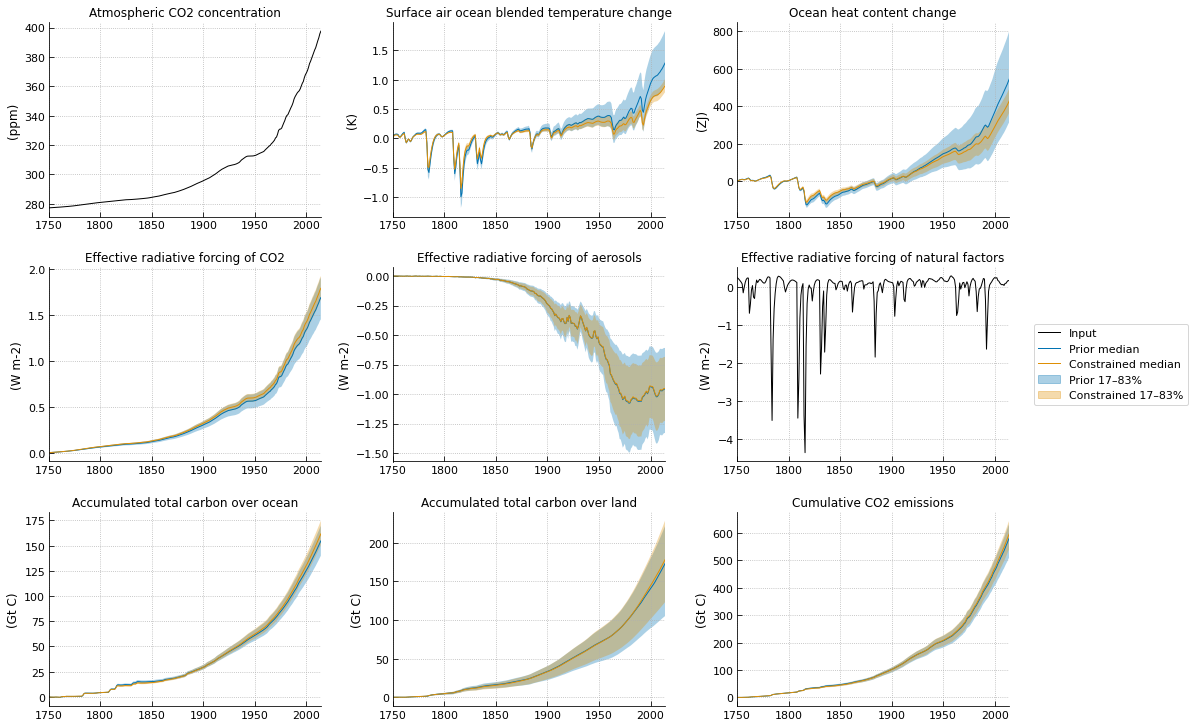

In [37]:
idx_year = pd.Index(din['time'])
year_lim = (idx_year[0], idx_year[-1])
slc = slice(
    idx_year.get_loc(year_lim[0]),
    idx_year.get_loc(year_lim[1]) + 1,
)
time = din['time'][slc]

myplt.init_regular(
    len(variable_order), col=3,
    kw_space={'height': 2.7, 'wspace': 1.},
)

for n, v1 in enumerate(variable_order):
    ax = myplt(n)

    if v1 in din:
        ax.plot(time, din[v1][slc], color='k')

    else:
        for i, ens in enumerate(ensemble_order):
            color = f'C{i}'
            ax.fill_between(
                time,
                y1=dout[ens][v1][2][slc],
                y2=dout[ens][v1][0][slc],
                edgecolor='none', facecolor=color, alpha=alpha,
            )
            ax.plot(time, dout[ens][v1][1][slc], color=color)

    ax.set_xlim(*year_lim)
    att = atts_ext.get(v1, atts['variables'].get(v1))
    if att is not None:
        ax.set_title(att['long_name'])
        ax.set_ylabel('({})'.format(att['units']))
    else:
        ax.set_title(v1)

    ax.grid()

_ = myplt.figure.legend(
    handles, labels,
    bbox_to_anchor=myplt.get_fig_position_relto_axes((1.02, 0.5)),
    loc='center left',
)

### SSP scenario runs

In [38]:
scenario = 'ssp245'
variable_order = ['tas', 'ohc']

with h5py.File(outpath, 'r') as f1:
    grp = f1[f'{scenario}/input']
    din = {k: v[:] for k, v in grp.items()}

    dout = {}
    for ens in ensemble_order:
        d1 = dout.setdefault(ens, {})
        for v1 in variable_order:
            d1[v1] = np.quantile(
                f1[f'{scenario}/{ens}/{v1}'][:], qvals, axis=0,
            )

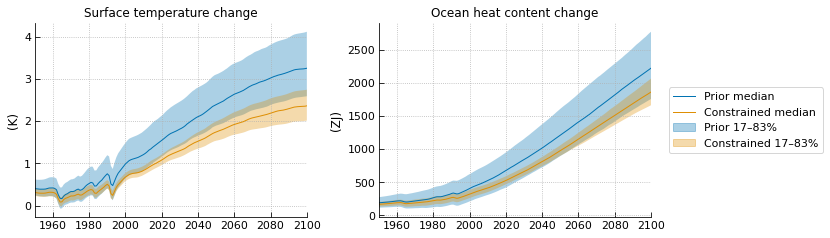

In [39]:
idx_year = pd.Index(din['time'])
year_lim = (1950, 2100)
slc = slice(
    idx_year.get_loc(year_lim[0]),
    idx_year.get_loc(year_lim[1]) + 1,
)
time = din['time'][slc]

myplt.init_regular(
    len(variable_order), col=3,
    kw_space={'height': 2.7, 'wspace': 1.},
)

for n, v1 in enumerate(variable_order):
    ax = myplt(n)

    for i, ens in enumerate(ensemble_order):
        color = f'C{i}'
        ax.fill_between(
            time,
            y1=dout[ens][v1][2][slc],
            y2=dout[ens][v1][0][slc],
            edgecolor='none', facecolor=color, alpha=alpha,
        )
        ax.plot(time, dout[ens][v1][1][slc], color=color)

    ax.set_xlim(*year_lim)
    att = atts_ext.get(v1, atts['variables'].get(v1))
    if att is not None:
        ax.set_title(att['long_name'])
        ax.set_ylabel('({})'.format(att['units']))
    else:
        ax.set_title(v1)

    ax.grid()

_ = myplt.figure.legend(
    handles[1:], labels[1:],
    bbox_to_anchor=myplt.get_fig_position_relto_axes((1.02, 0.5)),
    loc='center left',
)

## Selected indicators

In [40]:
qvals = [0.05, 0.17, 0.5, 0.83, 0.95]
indicators = {}

In [41]:
# Indicators from parameter ensembles

with h5py.File('untracked/parms_unconstrained_rcmip2.h5', 'r') as f1:
    d1 = {
        ens: get_parms_ens(f1, 'climate', ['ecs_reg'], mm).squeeze()
        for ens, mm in zip(labels_ens, [mm_prior, mm_constrained])
    }

indicators['ecs'] = {k: np.quantile(v, qvals) for k, v in d1.items()}

In [42]:
# Indicators from 1pctCO2 runs

scenario = '1pctCO2'

with h5py.File(outpath, 'r') as f1:
    for ens in ensemble_order:
        for v1, v2 in zip(
            ['tas', 'tcre', 'coct', 'cbst'],
            ['tcr', 'tcre', 'coct@y70_1pct', 'cbst@y70_1pct'],
        ):
            d1 = indicators.setdefault(v2, {})
            d1[ens] = np.quantile(
                f1[f'{scenario}/{ens}/{v1}'][:, 70], qvals,
            )

        for v1, v2 in zip(
            ['coct', 'cbst'],
            ['coct@y140_1pct', 'cbst@y140_1pct'],
        ):
            d1 = indicators.setdefault(v2, {})
            d1[ens] = np.quantile(
                f1[f'{scenario}/{ens}/{v1}'][:, 140], qvals,
            )

In [43]:
# Indicators from historical runs

scenario = 'historical'
year_base = 1750

i1 = 2011 - year_base
lab1 = '1750–2011'

with h5py.File(outpath, 'r') as f1:
    for ens in ensemble_order:
        for v1, v2 in zip(
            ['coct', 'cbst', 'ctot'],
            ['cocf', 'cbsf', 'eco2'],
        ):
            d1 = indicators.setdefault(f'{v1}@{lab1}', {})
            d1[ens] = np.quantile(
                f1[f'{scenario}/{ens}/{v1}'][:, i1]
                + f1[f'{scenario}/{ens}/{v2}'][:, i1] * 0.5,
                qvals,
            )

In [44]:
# Indicators from SSP scenario runs

scenario = 'ssp245'
year_base = 1850

with h5py.File(outpath, 'r') as f1:
    for ens in ensemble_order:
        slc = slice(
            2000 - year_base,
            2019 - year_base + 1,
        )
        slc0 = slice(
            1961 - year_base,
            1990 - year_base + 1,
        )
        lab1 = 'gmst@2000–2019 rel. to 1961–1990'
        d1 = indicators.setdefault(lab1, {})
        d1[ens] = np.quantile(
            f1[f'{scenario}/{ens}/tas'][:, slc].mean(axis=1)
            - f1[f'{scenario}/{ens}/tas'][:, slc0].mean(axis=1),
            qvals,
        )

        i0 = 1971 - year_base
        i1 = 2018 - year_base
        lab1 = 'ohc@2018 rel. to 1971'
        d1 = indicators.setdefault(lab1, {})
        d1[ens] = np.quantile(
            f1[f'{scenario}/{ens}/ohc'][:, i1]
            - f1[f'{scenario}/{ens}/ohc'][:, i0],
            qvals,
        )

In [45]:
# Indicators from forcing scales

scenario = 'ssp245'
year_base = 1850

# Time integration starts from 1850 with forcing relative to 1750
fmtlab = 'erf__{}@{} rel. to 1750'.format

# Here, reference year is 2014 for co2 and aerosols and 2011 for the others
map_year = {'co2': 2014, 'aerosols': 2014}

with h5py.File(outpath, 'r') as f1:
    cat = 'co2'
    year1 = map_year.get(cat, 2011)
    i1 = year1 - year_base
    d1 = indicators.setdefault(fmtlab(cat, year1), {})
    for ens in ensemble_order:
        d1[ens] = np.quantile(
            f1[f'{scenario}/{ens}/erf__{cat}'][:, i1],
            qvals,
        )

    din = {
        k[4:]: v[:]
        for k, v in f1[f'{scenario}/input'].items()
        if k.startswith('rf__')
    }
        
for cat in [
    'ch4', 'n2o', 'f_gases', 'montreal_gases', 'aerosols',
    'o3_strat', 'o3_trop',
]:
    year1 = map_year.get(cat, 2011)
    i1 = year1 - year_base

    for ens in ensemble_order:
        d1 = indicators.setdefault(fmtlab(cat, year1), {})
        d1[ens] = np.quantile(df_scale[(ens, cat)] * din[cat][i1], qvals)

    if f'erf__{cat}' not in atts_ext:
        atts_ext[f'erf__{cat}'] = {
            'long_name':
            atts['parameters']['forcing_scale'][cat]['long_name'].replace(
                'Scaling factor for',
                'Effective radiative forcing of',
            ),
            'units': 'W m-2',
        }

In [46]:
indicator_order = [
    'ecs', 'tcr',
    'gmst@2000–2019 rel. to 1961–1990', 'ohc@2018 rel. to 1971',
    'tcre', 'coct@1750–2011', 'cbst@1750–2011', 'ctot@1750–2011',
    'coct@y70_1pct', 'coct@y140_1pct', 'cbst@y70_1pct', 'cbst@y140_1pct',
    'erf__co2@2014 rel. to 1750', 'erf__ch4@2011 rel. to 1750',
    'erf__n2o@2011 rel. to 1750', 'erf__montreal_gases@2011 rel. to 1750',
    'erf__f_gases@2011 rel. to 1750', 'erf__aerosols@2014 rel. to 1750',
    'erf__o3_strat@2011 rel. to 1750', 'erf__o3_trop@2011 rel. to 1750',
]

In [47]:
def f_att(name):
    if name in atts_ext:
        att1 = atts_ext[name]
    elif name in atts['variables']:
        att1 = atts['variables'][name]
    elif name in atts['parameters']['climate']:
        att1 = atts['parameters']['climate'][name]
    else:
        att1 = {'long_name': name, 'units': ''}

    return att1['long_name'], att1['units'].replace(' ', '')

In [48]:
kw_errorbar = {
    'fmt': 'o', 'ls': 'None',
    'elinewidth': 1.5, 'capthick': 1.5, 'capsize': 6.,
}
colors = [f'C{i}' for i in range(len(ensemble_order))]

handles = [
    mpl.lines.Line2D([], [], ls='None', marker='^', color='k'),
    mpl.container.ErrorbarContainer(
        (
            mpl.lines.Line2D(
                [], [], ls='None', marker=kw_errorbar['fmt'], color='k',
            ),
            [mpl.lines.Line2D([], [], ls='None', color='k')],
            [
                mpl.collections.LineCollection(
                    np.empty((2, 2, 2)), colors='k',
                )
            ],
        ),
        has_xerr=True,
    ),
    mpl.lines.Line2D([], [], ls='None', marker='v', color='k'),
    mpl.patches.Patch(alpha=0, linewidth=0),
]

labels = [
    '{}%'.format(int(100*qvals[4]+0.5)),
    'Median, {}–{}%'.format(
        int(100*qvals[1]+0.5), int(100*qvals[3]+0.5),
    ),
    '{}%'.format(int(100*qvals[0]+0.5)),
    'Ensemble',
]

for i, ens in enumerate(ensemble_order):
    handles.append(mpl.lines.Line2D([], [], color=colors[i]))
    labels.append(ens)


In [49]:
handler_map = {
    type(handles[1]):
    mpl.legend_handler.HandlerErrorbar(xerr_size=1.),
}

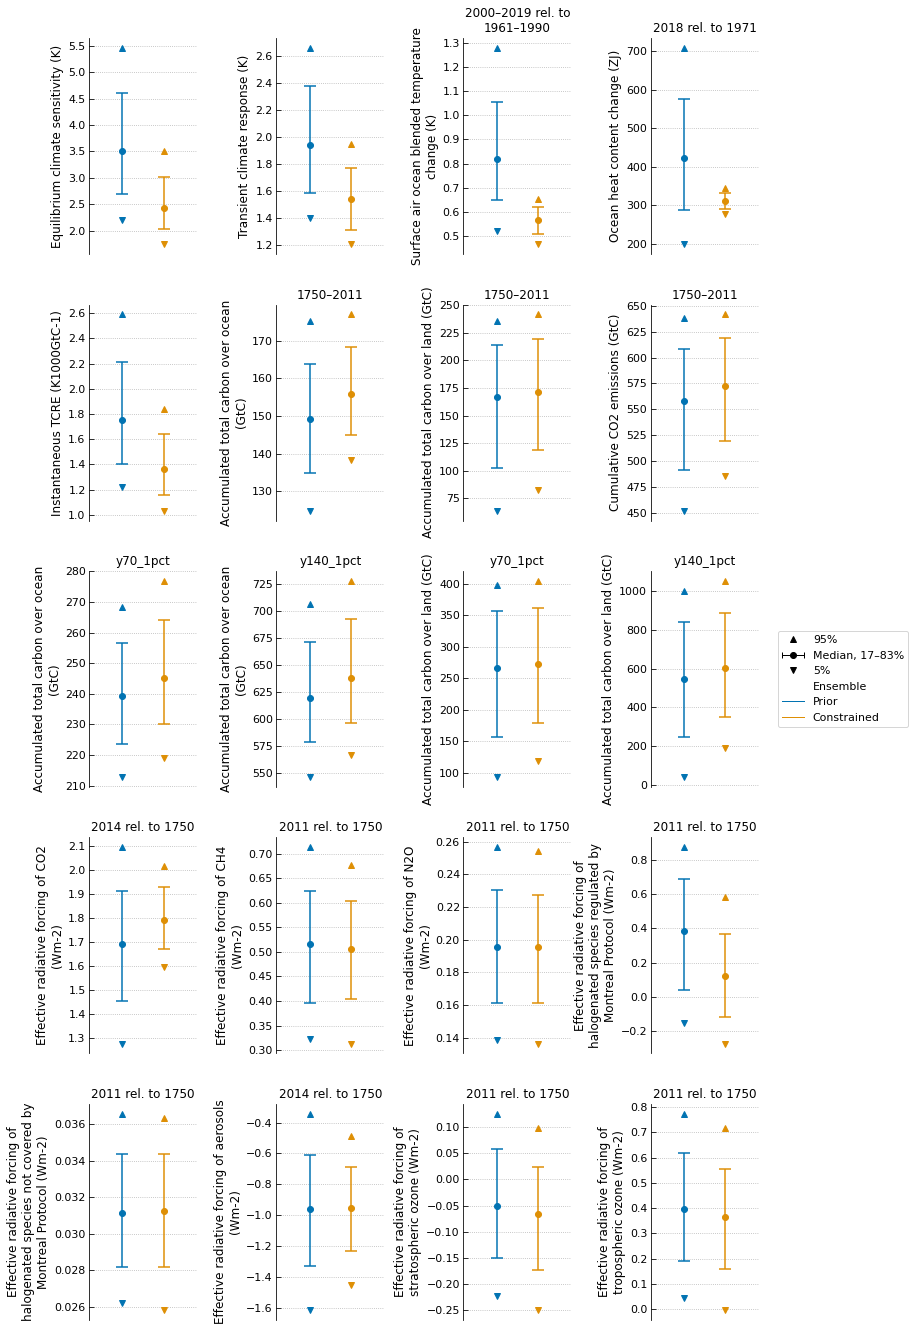

In [50]:
myplt.init_regular(
    len(indicators), col=4,
    kw_space={'aspect': 0.5, 'wspace': 1.1},
)

xvals = np.arange(len(ensemble_order)) + 0.5

for n, label in enumerate(indicator_order):
    ax = myplt(n)
    ax.spines['bottom'].set_visible(False)

    for i, ens in enumerate(ensemble_order):
        q = indicators[label][ens]
        ax.errorbar(
            [xvals[i]], [q[2]], yerr=[[q[2] - q[1]], [q[3] - q[2]]],
            ecolor=colors[i], mec=colors[i], mfc=colors[i], **kw_errorbar
        )
        ax.plot(xvals[i], q[0], ls='None', marker='v', color=colors[i])
        ax.plot(xvals[i], q[4], ls='None', marker='^', color=colors[i])

    label_p = label.split('@')
    ylabel = '{} ({})'.format(*f_att(label_p[0]))
    ax.set_ylabel('\n'.join(textwrap.wrap(ylabel, 40)))
    if len(label_p) > 1:
        ax.set_title('\n'.join(textwrap.wrap(label_p[1], 18)))

    ax.set_xlim(xvals[0]-0.8, xvals[-1]+0.8)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.grid(axis='y')

_ = myplt.figure.legend(
    handles, labels,
    bbox_to_anchor=myplt.get_fig_position_relto_axes((1.02, 0.5)),
    loc='center left', handler_map=handler_map,
)